In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

In [2]:
random_seed = 1024
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
data_root_lv = 'X:\\jechoi\\numpy\\Radiogenomics+genomics_raiomics_LAUD+LSCC\\train_val_test'

In [4]:
training_latent_variable_raw = np.load(data_root_lv + '\\training_latent_variable_noBatchNorm.npy')
training_label_bf = np.load(data_root_lv + '\\training_latent_variable_stage_noBatchNorm.npy')
validation_latent_variable_raw = np.load(data_root_lv + '\\validation_latent_variable_noBatchNorm.npy')
validation_label_bf = np.load(data_root_lv + '\\validation_latent_variable_stage_noBatchNorm.npy')
test_latent_variable_raw = np.load(data_root_lv + '\\test_latent_variable_noBatchNorm.npy')
test_label_bf = np.load(data_root_lv + '\\test_latent_variable_stage_noBatchNorm.npy')

In [5]:
training_latent_variable_max = training_latent_variable_raw.max()
training_latent_variable_min = training_latent_variable_raw.min()

In [6]:
training_latent_variable = (training_latent_variable_raw - training_latent_variable_min) / (training_latent_variable_max - training_latent_variable_min)
validation_latent_variable = (validation_latent_variable_raw - training_latent_variable_min) / (training_latent_variable_max - training_latent_variable_min)
test_latent_variable = (test_latent_variable_raw - training_latent_variable_min) / (training_latent_variable_max - training_latent_variable_min)

In [7]:
print(training_latent_variable.shape)
print(training_label_bf.shape)
print(validation_latent_variable.shape)
print(validation_label_bf.shape)
print(test_latent_variable.shape)
print(test_label_bf.shape)

(90, 512, 8, 8)
(90,)
(8, 512, 8, 8)
(8,)
(37, 512, 8, 8)
(37,)


In [8]:
label_one = len(np.where(training_label_bf == 1)[0]) / len(training_label_bf)
label_two = len(np.where(training_label_bf == 2)[0]) / len(training_label_bf)
label_three = len(np.where(training_label_bf == 3)[0]) / len(training_label_bf)
label_four = len(np.where(training_label_bf == 4)[0]) / len(training_label_bf)
print('one : ', label_one)
print('two : ', label_two)
print('three : ', label_three)
print('four  : ', label_four)

one :  0.6333333333333333
two :  0.2222222222222222
three :  0.1111111111111111
four  :  0.03333333333333333


In [9]:
val_label_one = len(np.where(validation_label_bf == 1)[0]) / len(validation_label_bf)
val_label_two = len(np.where(validation_label_bf == 2)[0]) / len(validation_label_bf)
val_label_three = len(np.where(validation_label_bf == 3)[0]) / len(validation_label_bf)
val_label_four = len(np.where(validation_label_bf == 4)[0]) / len(validation_label_bf)
print('one : ', val_label_one)
print('two : ', val_label_two)
print('three : ', val_label_three)
print('four : ', val_label_four)

one :  0.625
two :  0.25
three :  0.125
four :  0.0


In [10]:
test_label_one = len(np.where(test_label_bf == 1)[0]) / len(test_label_bf)
test_label_two = len(np.where(test_label_bf == 2)[0]) / len(test_label_bf)
test_label_three = len(np.where(test_label_bf == 3)[0]) / len(test_label_bf)
test_label_four = len(np.where(test_label_bf == 4)[0]) / len(test_label_bf)
print('one : ', test_label_one)
print('two : ', test_label_two)
print('three : ', test_label_three)
print('four  : ', test_label_four)

one :  0.5405405405405406
two :  0.40540540540540543
three :  0.05405405405405406
four  :  0.0


In [11]:
training_label = np.array([])
for i in training_label_bf:
    if i == 1:
        new_s = 0
    else:
        new_s = 1
    training_label = np.append(training_label, new_s)

In [12]:
validation_label = np.array([])
for i in validation_label_bf:
    if i == 1:
        new_s = 0
    else:
        new_s = 1
    validation_label = np.append(validation_label, new_s)

In [13]:
test_label = np.array([])
for i in test_label_bf:
    if i == 1:
        new_s = 0
    else:
        new_s = 1
    test_label = np.append(test_label, new_s)

In [14]:
label_one = len(np.where(training_label == 0)[0]) / len(training_label)
label_three = len(np.where(training_label == 1)[0]) / len(training_label)
print('early_stage : ', label_one)
print('late_stage : ', label_three)

early_stage :  0.6333333333333333
late_stage :  0.36666666666666664


In [15]:
val_label_one = len(np.where(validation_label == 0)[0]) / len(validation_label)
val_label_three = len(np.where(validation_label == 1)[0]) / len(validation_label)
print('early_stage : ', val_label_one)
print('late_stage : ', val_label_three)

early_stage :  0.625
late_stage :  0.375


In [16]:
test_label_one = len(np.where(test_label == 0)[0]) / len(test_label)
test_label_three = len(np.where(test_label == 1)[0]) / len(test_label)
print('early_stage : ', test_label_one)
print('late_stage : ', test_label_three)

early_stage :  0.5405405405405406
late_stage :  0.4594594594594595


In [17]:
flatten_train_X_raw= training_latent_variable.reshape(training_latent_variable.shape[0], -1).astype('float16')
flatten_test_X_raw = test_latent_variable.reshape(test_latent_variable.shape[0], -1).astype('float16')

In [18]:
flatten_train_X = (flatten_train_X_raw - flatten_train_X_raw.min()) / (flatten_train_X_raw.max() - flatten_train_X_raw.min())
flatten_test_X = (flatten_test_X_raw - flatten_test_X_raw.min()) / (flatten_test_X_raw.max() - flatten_test_X_raw.min())

In [19]:
pca_check = PCA(n_components=len(training_label))
pca_check.fit(flatten_train_X)

PCA(copy=True, iterated_power='auto', n_components=90, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [20]:
variance_ratio = pca_check.explained_variance_ratio_
variance_ratio_cum = np.array([])
value = 0
num_of_com = [i for i in range(0, len(training_label))]
for i in range(len(variance_ratio)):
        value += variance_ratio[i]
        variance_ratio_cum = np.append(variance_ratio_cum, value)

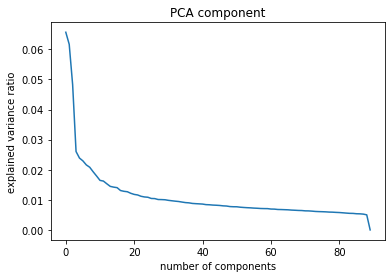

In [21]:
plt.plot(num_of_com, variance_ratio)
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')
plt.title('PCA component')
plt.show()

In [22]:
pca = PCA(n_components=10)
train_X_pca = pca.fit_transform(flatten_train_X)
test_X_pca = pca.transform(flatten_test_X)

In [23]:
# X_train = train_X_pca
# y_train = training_label
# X_test = test_X_pca
# y_test = test_label

In [24]:
X_train = flatten_train_X
y_train = training_label
X_test = flatten_test_X
y_test = test_label

In [25]:
svm_clf = Pipeline([
              ("linear_svc", SVC(kernel = 'linear', probability = True, random_state=random_seed))
])

svm_clf.fit(X_train, y_train)
y_hat_svm = svm_clf.predict(X_train)
y_predict_svm = svm_clf.predict(X_test)
svm_c_matrix_train = confusion_matrix(y_train, y_hat_svm)
acc_score_svm_train = (svm_c_matrix_train[0,0] + svm_c_matrix_train[1, 1]) / svm_c_matrix_train.sum()
sens_score_svm_train = svm_c_matrix_train[0,0] / svm_c_matrix_train.sum(axis=1)[0]
spec_score_svm_train = svm_c_matrix_train[1, 1] / svm_c_matrix_train.sum(axis=1)[1]
svm_c_matrix_test = confusion_matrix(y_test, y_predict_svm)
acc_score_svm_test = (svm_c_matrix_test[0,0] + svm_c_matrix_test[1, 1]) / svm_c_matrix_test.sum()
sens_score_svm_test = svm_c_matrix_test[0,0] / svm_c_matrix_test.sum(axis=1)[0]
spec_score_svm_test = svm_c_matrix_test[1, 1] / svm_c_matrix_test.sum(axis=1)[1]
y_predicted_prob_svm = svm_clf.predict_proba(X_test)
auc_svm = roc_auc_score(y_test, y_predicted_prob_svm[:,1])

svm_list = np.array([acc_score_svm_train, acc_score_svm_test, sens_score_svm_train, sens_score_svm_test, 
           spec_score_svm_train, spec_score_svm_test, auc_svm]).reshape(1, 7)

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state = random_seed)
rf.fit(X_train, y_train)
y_hat_rf = rf.predict(X_train)
y_predict_rf = rf.predict(X_test)
rf_c_matrix_train = confusion_matrix(y_train, y_hat_rf)
acc_score_rf_train = (rf_c_matrix_train[0,0] + rf_c_matrix_train[1, 1]) / rf_c_matrix_train.sum()
sens_score_rf_train = rf_c_matrix_train[0,0] / rf_c_matrix_train.sum(axis=1)[0]
spec_score_rf_train = rf_c_matrix_train[1, 1] / rf_c_matrix_train.sum(axis=1)[1]
rf_c_matrix_test = confusion_matrix(y_test, y_predict_rf)
acc_score_rf_test = (rf_c_matrix_test[0,0] + rf_c_matrix_test[1, 1]) / rf_c_matrix_test.sum()
sens_score_rf_test = rf_c_matrix_test[0,0] / rf_c_matrix_test.sum(axis=1)[0]
spec_score_rf_test = rf_c_matrix_test[1, 1] / rf_c_matrix_test.sum(axis=1)[1]

y_predicted_prob_rf = rf.predict_proba(X_test)
auc_svm = roc_auc_score(y_test, y_predicted_prob_rf[:, 1])

rf_list = np.array([acc_score_rf_train, acc_score_rf_test, sens_score_rf_train, sens_score_rf_test, 
          spec_score_rf_train, spec_score_rf_test, auc_svm]).reshape(1, 7)

In [27]:
svm_result = pd.DataFrame(svm_list, columns=['acc_train', 'acc_test', 'sen_train', 'sen_test', 
                                           'spe_train', 'spe_test', 'auc_test'], index = [str(i+1)])
rf_result = pd.DataFrame(rf_list, columns=['acc_train', 'acc_test', 'sen_train', 'sen_test', 
                                           'spe_train', 'spe_test', 'auc_test'], index = [str(i+1)])

In [28]:
svm_result

,acc_train,acc_test,sen_train,sen_test,spe_train,spe_test,auc_test
90,1.0,0.675676,1.0,0.65,1.0,0.705882,0.782353


In [29]:
rf_result

,acc_train,acc_test,sen_train,sen_test,spe_train,spe_test,auc_test
90,1.0,0.621622,1.0,0.95,1.0,0.235294,0.782353


In [30]:
y_predicted_prob_svm

array([[0.7343538 , 0.2656462 ],
       [0.64400941, 0.35599059],
       [0.47762947, 0.52237053],
       [0.75349466, 0.24650534],
       [0.46103042, 0.53896958],
       [0.64536643, 0.35463357],
       [0.40067771, 0.59932229],
       [0.69033277, 0.30966723],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.3720995 , 0.6279005 ],
       [0.68080122, 0.31919878],
       [0.64098775, 0.35901225],
       [0.5868811 , 0.4131189 ],
       [0.5       , 0.5       ],
       [0.56577377, 0.43422623],
       [0.52278196, 0.47721804],
       [0.49140812, 0.50859188],
       [0.31117544, 0.68882456],
       [0.35539042, 0.64460958],
       [0.48391167, 0.51608833],
       [0.47569596, 0.52430404],
       [0.79238975, 0.20761025],
       [0.75696076, 0.24303924],
       [0.8164517 , 0.1835483 ],
       [0.68887545, 0.31112455],
       [0.54377114, 0.45622886],
       [0.55262711, 0.44737289],
       [0.51017495, 0.48982505],
       [0.49073124, 0.50926876],
       [0.

In [31]:
y_test

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1.])

In [32]:
save_root = 'D:\\radiogenomics+radiomics_genomics_LAUD+LSCC'

In [33]:
svm_result.to_csv(save_root + '\\svm_result.csv')
rf_result.to_csv(save_root + '\\rf_result.csv')

In [34]:
roc_root = 'X:\\jechoi\\numpy\\Radiogenomics+genomics_raiomics_LAUD+LSCC\\train_val_test\\AUC data'

In [35]:
np.save(roc_root + '\\Unet+SVM\\probability.npy', y_predicted_prob_svm)
np.save(roc_root + '\\Unet+SVM\\test_real.npy', y_test)

In [36]:
np.save(roc_root + '\\Unet+RF\\probability.npy', y_predicted_prob_rf)
np.save(roc_root + '\\Unet+RF\\test_real.npy', y_test)

In [37]:
y_test = y_test.reshape(37, 1)
y_predict_svm = y_predict_svm.reshape(37, 1)
y_predict_rf = y_predict_rf.reshape(37, 1)

In [38]:
svm_output = np.append(y_test, y_predict_svm, axis = 1)
rf_output = np.append(y_test, y_predict_rf, axis = 1)

In [39]:
svm_output_pd = pd.DataFrame(svm_output, columns = ['real label', 'predicted label'])
rf_output_pd = pd.DataFrame(rf_output, columns = ['real label', 'predicted label'])

In [40]:
svm_output_pd.to_csv(save_root + '\\svm_output.csv')
rf_output_pd.to_csv(save_root + '\\rf_output.csv')